<a href="https://colab.research.google.com/github/313chengpeng/Analysis-of-tweets-about-chatgpt/blob/main/%E2%80%9C%E4%B8%BB%E9%A2%98%E5%BB%BA%E6%A8%A1_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用LDA进行主题建模

In [1]:
# 加载云端硬盘

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import re
from tqdm.auto import tqdm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# 导入数据

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bigdata/data_precess.csv', encoding='utf8')
# df.head(10)

# 数据清洗函数

In [4]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.4 MB/s eta 0:00:00


In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint 
# Gensim 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['amp','artificalintellig' ,'tcogfhukqnqz','chatgpt', 'ai', 'https', 'openai' ,'thing' , 'small', 'start' ,'one', 'artifical', 'intellig','bot','chatbot'])


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
# Import Dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bigdata/data_precess.csv', encoding='utf8')


In [7]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
# Convert to list
data = df['text'].tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# 去除链接和网址
data =  [re.sub(r"http\S+|www\S+", "",sent) for sent in data]
# 去除特殊字符和标点符号
data = [re.sub(r"\S+@\S+", "",sent) for sent in data]
data =  [re.sub(r"[^a-zA-Z0-9\s]+", "", sent) for sent in data]



print(data[:1])

['CannabisCommunity DeveloperStudentClubs domains domainnames domain ChatGPT DOMAINS domainnames domainforsale web3 nft ai dao Mmemberville Crypto Cryptocurency CryptoLover CryptoNews CryptoInvestor Great name for sale at  ']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['domains', 'domainnames', 'domain', 'chatgpt', 'domains', 'domainnames', 'domainforsale', 'web', 'nft', 'ai', 'dao', 'mmemberville', 'crypto', 'cryptocurency', 'cryptolover', 'cryptonews', 'cryptoinvestor', 'great', 'name', 'for', 'sale', 'at']]


In [9]:
# 创建二元（Bigram）模型和三元（Trigram）模型
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


/usr/local/lib/python3.9/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['domains_domainnames', 'domain', 'chatgpt', 'domains_domainnames_domainforsale', 'web', 'nft', 'ai', 'dao', 'mmemberville', 'crypto', 'cryptocurency', 'cryptolover', 'cryptonews', 'cryptoinvestor', 'great', 'name', 'for', 'sale', 'at']


In [10]:
 # Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
     """https://spacy.io/api/annotation"""
     texts_out = []
     for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
     return texts_out
 
 
 # Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['domains_domainname', 'domain', 'domains_domainname', 'web', 'cryptoinvestor', 'great', 'name', 'sale']]


In [11]:
 # Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
 # Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
 # View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                            num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                          alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.023*"use" + 0.023*"ask" + 0.020*"write" + 0.015*"get" + 0.014*"make" + 0.012*"answer" + 0.012*"good" + 0.011*"new" + 0.010*"question" + 0.010*"know"'), (1, '0.027*"code" + 0.023*"take" + 0.017*"human" + 0.015*"day" + 0.011*"job" + 0.010*"replace" + 0.010*"content" + 0.009*"bitcoin" + 0.008*"seem" + 0.008*"digital"'), (2, '0.037*"gpt" + 0.019*"play" + 0.018*"chat" + 0.017*"tweet" + 0.016*"art" + 0.014*"web" + 0.013*"cool" + 0.011*"impressive" + 0.011*"game" + 0.010*"image"'), (3, '0.018*"future" + 0.018*"technology" + 0.015*"world" + 0.015*"learn" + 0.014*"potential" + 0.012*"change" + 0.012*"model" + 0.011*"student" + 0.011*"tech" + 0.008*"machinelearning"')]


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.396458  0.010940       1        1  53.604105
1     -0.144621  0.317994       2        1  18.020591
3     -0.127567 -0.235058       3        1  17.119254
2     -0.124270 -0.093875       4        1  11.256050, topic_info=              Term          Freq         Total Category  logprob  loglift
72             gpt   4234.000000   4234.000000  Default  30.0000  30.0000
89            code   4933.000000   4933.000000  Default  29.0000  29.0000
65             use  12718.000000  12718.000000  Default  28.0000  28.0000
35             ask  12620.000000  12620.000000  Default  27.0000  27.0000
324           take   4226.000000   4226.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
2751         movie    434.277530    435.109271   Topic4  -5.5801   2.1824
435      community    440.738170    441.585994   Topic4  -5.5653   2.1823
1916        mighty    548.916591    550.142192   Topic4  -5.3459   2.1820
413           play   2156.176364   2331.719489   Topic4  -3.9777   2.1060
38191  musictheory    485.670984    500.478662   Topic4  -5.4683   2.1542

[161 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
86        2  0.999279  ability
696       4  0.998981    aiart
349       1  0.999846   answer
3001      4  0.999286      art
2054      4  0.998224   artist
...     ...       ...      ...
67        1  0.999801     well
531       2  0.999057     word
333       1  0.999782     work
652       3  0.999655    world
186       1  0.999916    write

[140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

In [15]:
 # Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.4115748027862

Coherence Score:  0.25148143101735193


In [16]:
pyLDAvis.save_html(vis, 'lda_model_vis.html')

# 统计不同主题下的推文数量

In [17]:
pip install pyecharts


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.1/146.1 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 9.1 MB/s eta 0:00:00


In [18]:
pip install pyecharts_snapshot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 6.5 MB/s eta 0:00:00


In [19]:
topic_count = []
for i in range(4):
    topic_docs = lda_model.get_document_topics(corpus)
    count = 0
    for doc in topic_docs:
        if doc[i][1] > 0.1:
            count += 1
    topic_count.append(count)
print(topic_count)


[117021, 113803, 55768, 109127]


In [20]:
from pyecharts import options as opts
from pyecharts.charts import Bar

bar = (
    Bar()
    .add_xaxis(["Topic 1", "Topic 2", "Topic 3", "Topic 4"])
    .add_yaxis("Count", topic_count)
    .set_global_opts(title_opts=opts.TitleOpts(title="Topic Count"))
)

bar.render("topic_count_bar_chart.html")
bar.render_notebook()

In [24]:
from textblob import TextBlob

topic_sentiments = []
for i in range(4):
    topic_docs = lda_model.get_document_topics(corpus)
    doc_scores = []
    for j, doc in enumerate(topic_docs):
        if doc[i][1] > 0.1:
            doc_scores.append((j, doc[i][0], doc[i][1]))
    doc_scores = sorted(doc_scores, key=lambda x: x[2], reverse=True)[:100]
    sentiments = {"positive": 0, "neutral": 0, "negative": 0}
    for doc_score in doc_scores:
        text = texts[doc_score[0]]
        text_str = " ".join(text)
        blob = TextBlob(text_str)
        sentiment = blob.sentiment.polarity
        if sentiment > 0:
            sentiments["positive"] += 1
        elif sentiment == 0:
            sentiments["neutral"] += 1
        else:
            sentiments["negative"] += 1
    topic_sentiments.append(sentiments)
print(topic_sentiments)


[{'positive': 72, 'neutral': 5, 'negative': 23}, {'positive': 41, 'neutral': 49, 'negative': 10}, {'positive': 8, 'neutral': 34, 'negative': 58}, {'positive': 27, 'neutral': 70, 'negative': 3}]


In [27]:
y_data=[[72,5,23],[41,49,10],[8,34,58],[27,70,3]]

<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<ipython-input-27-77e42a2b453d>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  y_data=[[72,5,23] [41,49,10] [8,34,58] [27,70,3]]


TypeError: ignored

In [28]:
y_data

[[72, 5, 23], [41, 49, 10], [8, 34, 58], [27, 70, 3]]

# 不同主题下的情感分析

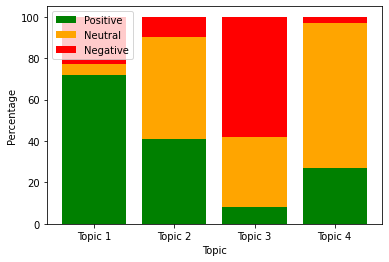

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# 设置数据
y_data = np.array(y_data)
x_data = range(len(y_data))

# 绘制堆叠柱状图
fig, ax = plt.subplots()
colors = ['green', 'orange', 'red']
labels = ['Positive', 'Neutral', 'Negative']
bottom = np.zeros(len(y_data))
for i in range(3):
    ax.bar(x_data, y_data[:, i], color=colors[i], label=labels[i], bottom=bottom)
    bottom += y_data[:, i]
ax.set_xticks(x_data)
ax.set_xticklabels([f'Topic {i}' for i in range(1, len(x_data)+1)])
ax.set_xlabel('Topic')
ax.set_ylabel('Percentage')
ax.legend()
plt.show()


In [30]:
plt.savefig('stacked_bar.png')

<Figure size 432x288 with 0 Axes>

# 看下6个主题的效果

In [31]:
# Build LDA model
lda_model_6 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                            num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                          alpha='auto',
                                           per_word_topics=True)

In [32]:
# Print the Keyword in the 10 topics
print(lda_model_6.print_topics())
doc_lda_6 = lda_model_6[corpus]

[(0, '0.053*"ask" + 0.035*"get" + 0.032*"make" + 0.027*"answer" + 0.024*"question" + 0.023*"try" + 0.022*"go" + 0.020*"time" + 0.018*"give" + 0.018*"well"'), (1, '0.038*"take" + 0.029*"people" + 0.019*"job" + 0.017*"replace" + 0.016*"year" + 0.015*"pretty" + 0.012*"user" + 0.011*"long" + 0.010*"able" + 0.009*"tedious"'), (2, '0.054*"gpt" + 0.028*"search" + 0.026*"chat" + 0.012*"wait" + 0.011*"do" + 0.011*"lol" + 0.011*"soon" + 0.010*"meet" + 0.010*"current" + 0.010*"little"'), (3, '0.029*"play" + 0.024*"tweet" + 0.021*"hour" + 0.016*"game" + 0.016*"finally" + 0.016*"awesome" + 0.014*"break" + 0.010*"difference" + 0.009*"admit" + 0.009*"hack"'), (4, '0.038*"use" + 0.033*"write" + 0.019*"good" + 0.019*"new" + 0.017*"know" + 0.016*"think" + 0.015*"see" + 0.014*"code" + 0.014*"work" + 0.014*"create"'), (5, '0.020*"human" + 0.018*"future" + 0.017*"technology" + 0.014*"world" + 0.013*"potential" + 0.013*"research" + 0.012*"love" + 0.012*"change" + 0.012*"art" + 0.012*"model"')]


In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_6 = pyLDAvis.gensim.prepare(lda_model_6, corpus, id2word)
vis_6


/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.416609  0.073926       1        1  33.981784
0      0.008830 -0.411496       2        1  22.118103
5      0.100530  0.093728       3        1  16.273441
1      0.104882  0.090982       4        1  11.369352
2      0.099951  0.076392       5        1   8.369050
3      0.102417  0.076467       6        1   7.888271, topic_info=          Term          Freq         Total Category  logprob  loglift
35         ask  12013.000000  12013.000000  Default  30.0000  30.0000
65         use  13248.000000  13248.000000  Default  29.0000  29.0000
186      write  11454.000000  11454.000000  Default  28.0000  28.0000
581        get   7933.000000   7933.000000  Default  27.0000  27.0000
72         gpt   4619.000000   4619.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1488     ready    453.747135    454.620394   Topic6  -5.1807   2.5379
2204    advice    419.431932    420.305962   Topic6  -5.2594   2.5377
2907      blow    419.566848    420.442111   Topic6  -5.2590   2.5377
1321   support    402.916372    403.790245   Topic6  -5.2995   2.5376
2966  complete    401.229572    402.103341   Topic6  -5.3037   2.5376

[217 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
434       4  0.999225    able
1302      6  0.998843   admit
2204      6  0.996893  advice
1800      5  0.999082   agree
696       5  0.999326   aiart
...     ...       ...     ...
652       3  0.999513   world
186       1  0.999916   write
701       4  0.999001  writer
1247      2  0.999508   wrong
1146      4  0.999431    year

[191 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 6, 2, 3, 4])

In [37]:
# Build LDA model
lda_model_5 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                            num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                          alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 10 topics
print(lda_model_5.print_topics())
doc_lda_5 = lda_model_5[corpus]

[(0, '0.042*"ask" + 0.028*"get" + 0.025*"make" + 0.021*"answer" + 0.019*"question" + 0.019*"know" + 0.018*"try" + 0.018*"think" + 0.017*"go" + 0.015*"time"'), (1, '0.037*"take" + 0.019*"job" + 0.017*"research" + 0.017*"replace" + 0.016*"art" + 0.015*"web" + 0.012*"digital" + 0.010*"business" + 0.008*"developer" + 0.007*"implication"'), (2, '0.040*"m" + 0.040*"gpt" + 0.021*"tell" + 0.019*"chat" + 0.018*"tweet" + 0.010*"able" + 0.009*"style" + 0.009*"poem" + 0.009*"wait" + 0.008*"output"'), (3, '0.023*"technology" + 0.020*"play" + 0.019*"world" + 0.016*"change" + 0.015*"model" + 0.014*"tech" + 0.013*"next" + 0.011*"game" + 0.010*"awesome" + 0.010*"internet"'), (4, '0.036*"use" + 0.031*"write" + 0.018*"good" + 0.018*"new" + 0.014*"see" + 0.014*"code" + 0.013*"work" + 0.013*"create" + 0.011*"well" + 0.010*"generate"')]


In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_5 = pyLDAvis.gensim.prepare(lda_model_5, corpus, id2word)
vis_5

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.330765  0.233166       1        1  36.129058
0      0.148574 -0.370932       2        1  29.293913
3     -0.159071  0.047967       3        1  12.715160
1     -0.160811  0.046545       4        1  11.754851
2     -0.159458  0.043254       5        1  10.107019, topic_info=                 Term          Freq         Total Category  logprob  loglift
35                ask  12516.000000  12516.000000  Default  30.0000  30.0000
65                use  13308.000000  13308.000000  Default  29.0000  29.0000
186             write  11506.000000  11506.000000  Default  28.0000  28.0000
581               get   8265.000000   8265.000000  Default  27.0000  27.0000
324              take   4495.000000   4495.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
8424     hypothetical    561.729862    562.708033   Topic5  -5.2151   2.2902
2496             mine    542.205777    543.185892   Topic5  -5.2505   2.2901
935   stablediffusion    447.890409    448.741738   Topic5  -5.4416   2.2900
8002            silly    540.352176    541.409602   Topic5  -5.2539   2.2900
4548           jasper    509.168402    510.173192   Topic5  -5.3133   2.2900

[199 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
434       5  0.999452      able
1551      3  0.998083  accurate
874       2  0.999744  actually
1800      5  0.997614     agree
696       5  0.998364     aiart
...     ...       ...       ...
652       3  0.999826     world
186       1  0.999958     write
701       4  0.998617    writer
1146      2  0.999331      year
1531      3  0.999228       yet

[183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 2, 3])